UNet++

In [1]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam


c:\Users\srika\anaconda3\envs\king\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
DATA_DIR = 'Data/'
LABELS_CSV = 'LungCT-Labels - Sheet1.csv'
IMG_SIZE_PX = 150
SLICE_COUNT = 20

In [3]:
# convolution block with batch normalization and ReLU activation
def conv_block(x, filters, kernel_size=3):
    x = layers.Conv3D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

In [4]:
# Nested convolutional blocks for UNet++
def nested_block(input_tensor, filters, depth):
    x = input_tensor
    skips = []
    
    for i in range(depth):
        x = conv_block(x, filters)
        skips.append(x)
    
    # Concatenate all skip connections
    x = layers.Concatenate()(skips)
    return x

In [5]:
from tensorflow.keras import layers, Model, Input

def build_unetplusplus_3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1), num_classes=2, depth=3, filters=32):
    inputs = Input(shape=input_shape)
    
    # Encoder pathway with nested dense skip connections
    enc1 = nested_block(inputs, filters, depth=depth)
    pool1 = layers.MaxPooling3D(pool_size=2)(enc1)
    
    enc2 = nested_block(pool1, filters * 2, depth=depth)
    pool2 = layers.MaxPooling3D(pool_size=2)(enc2)
    
    enc3 = nested_block(pool2, filters * 4, depth=depth)
    pool3 = layers.MaxPooling3D(pool_size=2)(enc3)
    
    enc4 = nested_block(pool3, filters * 8, depth=depth)

    # Decoder pathway with upsampling and skip connections
    up3 = layers.UpSampling3D(size=2)(enc4)
    
    # Ensure matching shape between up3 and enc3 by applying padding
    up3_shape = list(up3.shape[1:])  # Convert shape to list
    enc3_shape = list(enc3.shape[1:])  # Convert shape to list
    
    # Calculate the padding required
    padding = [(max(0, enc3_shape[i] - up3_shape[i]), 0) for i in range(3)]
    
    # Apply padding to up3 to match enc3's shape
    up3 = layers.ZeroPadding3D(padding=padding)(up3)
    
    # Now, the dimensions should match. Apply concatenation.
    concat3 = layers.Concatenate()([up3, enc3])
    
    # Apply the nested block after concatenation
    dec3 = nested_block(concat3, filters * 4, depth=depth)
    
    up2 = layers.UpSampling3D(size=2)(dec3)
    
    # Repeat the process for subsequent layers
    up2_shape = list(up2.shape[1:])
    enc2_shape = list(enc2.shape[1:])
    
    padding = [(max(0, enc2_shape[i] - up2_shape[i]), 0) for i in range(3)]
    up2 = layers.ZeroPadding3D(padding=padding)(up2)
    
    concat2 = layers.Concatenate()([up2, enc2])
    dec2 = nested_block(concat2, filters * 2, depth=depth)
    
    up1 = layers.UpSampling3D(size=2)(dec2)
    
    up1_shape = list(up1.shape[1:])
    enc1_shape = list(enc1.shape[1:])
    
    padding = [(max(0, enc1_shape[i] - up1_shape[i]), 0) for i in range(3)]
    up1 = layers.ZeroPadding3D(padding=padding)(up1)
    
    concat1 = layers.Concatenate()([up1, enc1])
    dec1 = nested_block(concat1, filters, depth=depth)

    # Global Average Pooling and Output Layer for classification
    x = layers.GlobalAveragePooling3D()(dec1)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model


In [6]:
def load_data(data_dir, labels_df, img_size_px=IMG_SIZE_PX, hm_slices=SLICE_COUNT):
    image_full_data = []
    
    patients = os.listdir(data_dir)

    for patient in patients:
        label = labels_df.at[patient, 'Labels']
        path = os.path.join(data_dir, patient)
        slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
        slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array), (img_size_px, img_size_px)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for i in range(0, len(slices), chunk_sizes):
            slice_chunk = slices[i:i + chunk_sizes]
            if len(slice_chunk) > 0:
                new_slices.append(np.mean(slice_chunk, axis=0))

        if len(new_slices) < hm_slices:
            last_slice = new_slices[-1]
            while len(new_slices) < hm_slices:
                new_slices.append(last_slice)

        image_full_data.append([new_slices, np.array([1, 0]) if label == 1 else np.array([0, 1])])

    return image_full_data


In [7]:
labels_df = pd.read_csv(LABELS_CSV, index_col=0)

image_full_data = load_data(DATA_DIR, labels_df)


In [8]:
np.random.shuffle(image_full_data)
train_data = image_full_data[:int(len(image_full_data) * 0.8)]
validation_data = image_full_data[int(len(image_full_data) * 0.8):]

train_X = np.array([data[0] for data in train_data])
train_Y = np.array([data[1] for data in train_data])
valid_X = np.array([data[0] for data in validation_data])
valid_Y = np.array([data[1] for data in validation_data])


In [9]:
train_X = train_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))
valid_X = valid_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))

model = build_unetplusplus_3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))

In [10]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 150, 15  0           []                               
                                0, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 20, 150, 150  896         ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 150, 150  128        ['conv3d[0][0]']                 
 alization)                     , 32)                                                         

In [11]:
history = model.fit(train_X, train_Y, batch_size=1, epochs=10, validation_data=(valid_X, valid_Y))


Epoch 1/10
48/48 [==============================] - 176s 3s/step - loss: 0.6913 - accuracy: 0.5417 - val_loss: 0.7045 - val_accuracy: 0.6154
Epoch 2/10
48/48 [==============================] - 155s 3s/step - loss: 0.6822 - accuracy: 0.6042 - val_loss: 0.7457 - val_accuracy: 0.3846
Epoch 3/10
48/48 [==============================] - 152s 3s/step - loss: 0.6770 - accuracy: 0.6042 - val_loss: 2.2194 - val_accuracy: 0.3846
Epoch 4/10
48/48 [==============================] - 152s 3s/step - loss: 0.6729 - accuracy: 0.6042 - val_loss: 1.5344 - val_accuracy: 0.3846
Epoch 5/10
48/48 [==============================] - 155s 3s/step - loss: 0.6737 - accuracy: 0.6042 - val_loss: 1.4902 - val_accuracy: 0.3077
Epoch 6/10
48/48 [==============================] - 155s 3s/step - loss: 0.6790 - accuracy: 0.6042 - val_loss: 3.4136 - val_accuracy: 0.3077
Epoch 7/10
48/48 [==============================] - 155s 3s/step - loss: 0.6741 - accuracy: 0.6042 - val_loss: 0.8572 - val_accuracy: 0.3846
Epoch 8/10
48

In [12]:
model.save("unetplusplus_3d_model.h5")


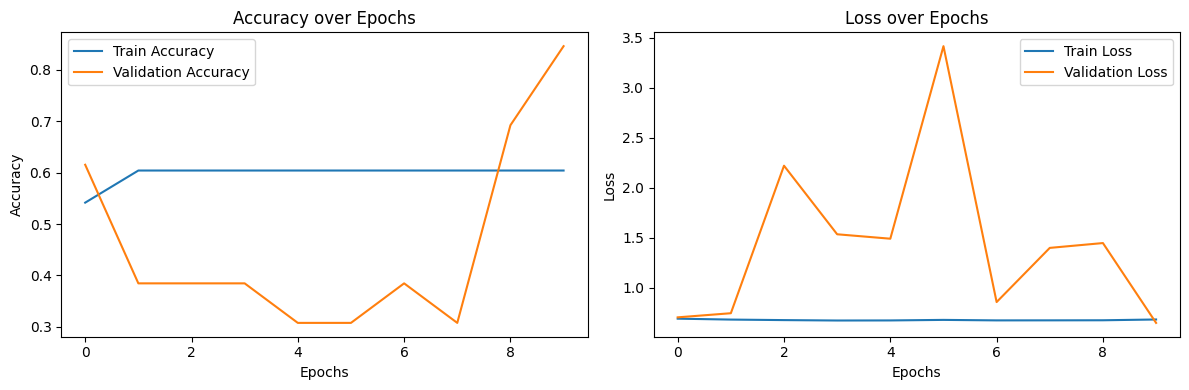

In [13]:
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)